# Clustering river profiles for geomorphology

This is a tutorial on how to perform agglomerative hierarchical clustering on river profiles, using an example from the Pozo catchment, Santa Cruz Island.  We can use this to classify the landscape into different domains, which can be used to explore erosion rates, lithology, or the influence of climate and tectonics on landscapes.  You can find more details of the method in this paper:

Clubb, F.J., Bookhagen, B. and Rheinwalt, A. (2019) Clustering River Profiles to Classify Geomorphic Domains, _JGR: Earth Surface_, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005025

You can find all the code in this GitHub repository. This repository is organised so that the code required to perform the clustering and plotting is stored in separate files, and the file `cluster-river-profiles.py` can be run as a command line wrapper. This notebook is an alternative to this wrapper script that walks through how to perform the clustering in a bit more detail.

**IMPORTANT**: The example data are too big to store on GitHub. The first step is to download these data and store it in the same folder as the code:
https://durhamuniversity-my.sharepoint.com/:u:/g/personal/bjdd72_durham_ac_uk/Ee-oVKcprrBHvaYWsVhjJ1MB0VLblXKib4bkEZV4wCIqxQ?e=TMsRqT

If you don't do this, then the rest of the notebook won't work!
We firstly extract the data from the compressed archive:

In [ ]:
import tarfile
tf = tarfile.open("example_data.tar.gz")
tf.extractall()

The next step is to import the required functions:

In [1]:
# Firstly, import the required files and set matplotlib to show plots in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import clustering as cl
import plotting as pl
import raster_plotting as rpl

After importing the scripts, we need to define a few arguments in the block below:
1. `data_dir`: The data directory. We'll use the `example_data` directory in this repository.
2. `fname`: The name of the DEM. In this example, we'll use the Pozo catchment, and the file is called `Pozo_DTM`
3. `step`: This is the spacing that you want the profiles to have for the clustering. This is dependent on the resolution of your DEM. Here we're using a 1 m DEM, so we'll use a 2 m spacing.
4. `so`: The stream order of the rivers that you wish to perform the clustering over. Here we'll focus on the first order streams, so we'll set `so = 1` 

In [2]:
# User-defined variables
data_dir = './example_data/'
fname = 'Pozo_DTM'
step = 2
so = 1

We then need some additional variables which you should keep constant in all runs.

In [3]:
# Additional variables
slope_window = 25    # the window size for calculating the slope
min_length = 5       # the minimum length of a stream for it to be included in the clustering (in  nodes)
method = 'ward'      # the method for clustering. See Scipy docs for more details: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html


The code uses a `csv` file, in this case `Pozo_DTM_all_tribs.csv`, to perform the clustering. This csv file simply lists the latitude and longitude of every point in the river network, along with other variables such as drainage area and elevation. You can create this file however you want: I do it using LSDTopoTools[https://github.com/LSDtopotools/LSDTopoTools2], but you could also use TopoToolbox or your own Python code.  Just make sure it follows the same structure as the file provided in this repository.

We use `pandas` to read in the csv file to a dataframe, and then calculate the slope at each point along the river using a moving window approach. This will take quite a few minutes to run: it's the slowest part of the process. This function produces a figure showing the slope of all the profiles - we can see it's pretty messy!

In [4]:
# read in the csv file with the river network
df = pd.read_csv(data_dir+fname+'_all_tribs.csv')
print("Got the csv of the channel network")
print(df)

Got the csv of the channel network
         basin_id    id      node  distance_from_outlet   elevation  \
0             208   169   1124213           3796.740000  229.030000   
1             208   169   1127468           3795.738280  228.839996   
2             208   169   1130726           3794.738280  228.639999   
3             208   169   1133985           3793.738280  228.509995   
4             208   169   1137247           3792.324220  228.369995   
...           ...   ...       ...                   ...         ...   
1732516       208  2345  12071170              3.414173    9.380000   
1732517       208  2345  12074400              1.999976    9.349999   
1732518       208  2345  12071168              0.999988    9.340000   
1732519       208  2345  12071167              0.000000    9.320000   
1732520       208  2345  12071166              0.000000    9.290000   

         drainage_area  stream_order   latitude   longitude     slope  
0         1.609960e+03             1  34

After calculating the slope, we then get the profiles for the chosen stream order and step spacing:

We can make a plot of the profiles for this stream order - it looks pretty messy!

Assigning the profiles a common distance step of 2 m


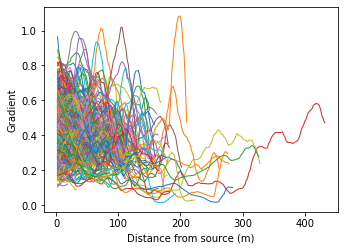

In [5]:
# get the profiles for the chosen stream order
so_df = cl.GetProfilesByStreamOrder(data_dir, fname, df, step, slope_window, so)

# if stream order is greater than one, remove any non-unique profiles
if so > 1:
    so_df = cl.RemoveNonUniqueProfiles(so_df)

# remove any profiles shorter than the threshold length
so_df = cl.RemoveProfilesShorterThanThresholdLength(so_df, min_length)

We then perform the clustering. To do this we select a "threshold level", which helps to determine the number of clusters. To get the grouping with the most distinct clusters, we set the threshold level to 0:

Now I'm going to do some hierarchical clustering...
The optimum distance threshold is 0.6173826783229148
I've finished! I found 2 clusters for you :)


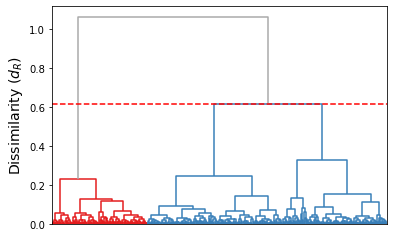

In [6]:
threshold_level = 0
# perform the clustering and save the output as a dataframe
cluster_df = cl.ClusterProfilesVaryingLength(data_dir, data_dir, fname, so_df, method, so, threshold_level)

The graph above shows the dendrogram of how all the rivers are related to each other. The threshold level is marked with the red line. You can try changing the `threshold_level` to 1 to see how this changes the cutting of the dendrogram and the number of clusters.

This function returns the river profiles as dataframe (`cluster_df`) which has the cluster ID assigned to each river. We can use this to do some more plotting. For example, we can plot the profiles separately by cluster:

Making plots of the river profiles in each cluster


,basin_id,id,node,distance_from_outlet,elevation,drainage_area,stream_order,latitude,longitude,slope,reg_dist,cluster_id,colour
0,208.0,169.0,1130726.0,3794.738280,228.639999,1613.96143,1.0,34.002034,-119.858091,0.193978,2.0,1.0,#e41a1c
1,208.0,169.0,1137247.0,3792.324220,228.369995,1963.95312,1.0,34.002016,-119.858090,0.188029,4.0,1.0,#e41a1c
2,208.0,169.0,1143777.0,3790.323970,228.059998,2285.94531,1.0,34.001999,-119.858079,0.183794,6.0,1.0,#e41a1c
3,208.0,169.0,1150315.0,3788.323970,227.470001,2332.94434,1.0,34.001981,-119.858078,0.186198,8.0,1.0,#e41a1c
4,208.0,169.0,1156861.0,3786.323730,226.809998,2345.94385,1.0,34.001963,-119.858077,0.182705,10.0,1.0,#e41a1c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14754,208.0,2345.0,12721408.0,997.087463,120.589996,2322.94482,1.0,33.978466,-119.854369,0.231784,8.0,1.0,#e41a1c
14755,208.0,2345.0,12721407.0,995.673218,120.299995,2325.94434,1.0,33.978466,-119.854380,0.233571,10.0,1.0,#e41a1c
14756,208.0,2345.0,12719715.0,993.673279,119.570000,2347.94385,1.0,33.978475,-119.854401,0.233928,12.0,1.0,#e41a1c
14757,208.0,2345.0,12718023.0,991.673340,119.250000,2413.94238,1.0,33.978483,-119.854413,0.228157,14.0,1.0,#e41a1c


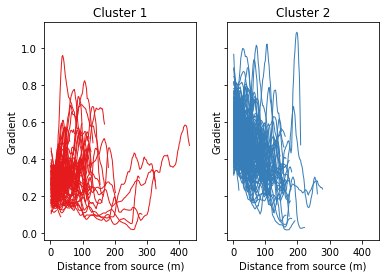

In [7]:
# plot the gradient vs. distance from source for each cluster
pl.PlotProfilesByCluster(data_dir, data_dir, fname, so)

We can aggregate these profiles by plotting the median profile in each cluster:

I'm making plots of the median profiles for each cluster


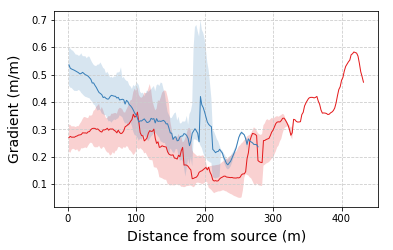

In [8]:
# plot the median profiles by cluster
pl.PlotMedianProfiles(data_dir, data_dir, fname, so)

We can also make a plot of the hillshade of the catchment with the river network coloured by the cluster number:

I'm plotting a shaded relief map with the channels coloured by cluster


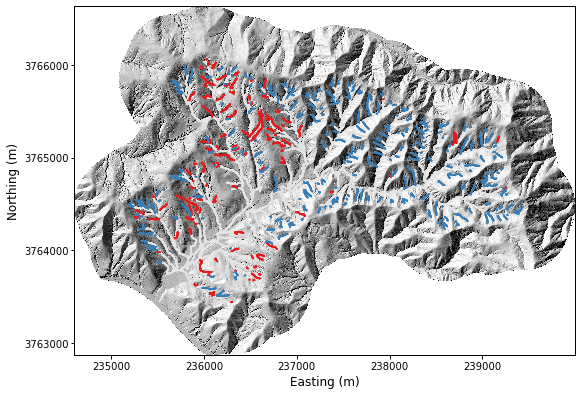

In [9]:
# make a hillshade plot of the raster with the clusters overlain
rpl.PlotHillshadewithClusters(data_dir, data_dir, fname, so)

In the case of the Pozo catchment, we can see that there seems to be a distinct grouping of the clusters with
1. Profiles in the red cluster near the outlet of the catchment
2. Profiles in the blue cluster near the headwaters

We can compare this to the geological map:

The geology raster is Pozo_geology.tif
N axes are: 1
Axes(0,0;1x1)
N colours: 10
The number of axes are: 2


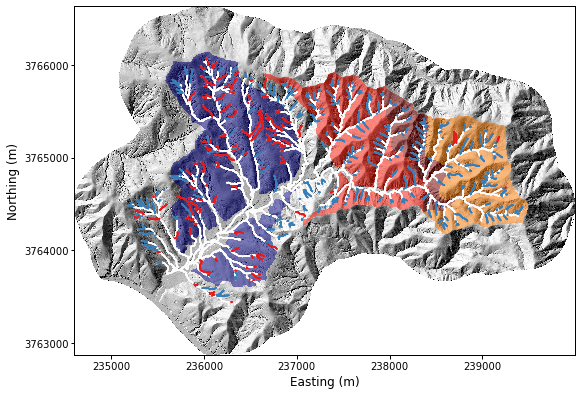

In [10]:
geol_raster = 'Pozo_geology.tif'
rpl.PlotRasterLithologyWithClusters(data_dir, data_dir, fname, so, geol_raster)

We can see that the majority of profiles in the red cluster fall within the blue lithology, a weakly resistant shale, compared to the profiles in the blue cluster which fall within the orange-brown lithologies (more resistant volcaniclastics). In this case, the morphology of river profiles is dominated by lithology!